# What impact does the noise level have on our "Basic Extraction"

Just a small study

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm, trange
np.random.seed(0)

In [2]:
def fact_pulse_in_mV(x, x0=0):
    from numpy import exp
    p = (1.239*(1-1/(1+exp(((x-x0)-2.851)/1.063)))*exp(-((x-x0)-2.851)/19.173))
    p *= 10
    return p

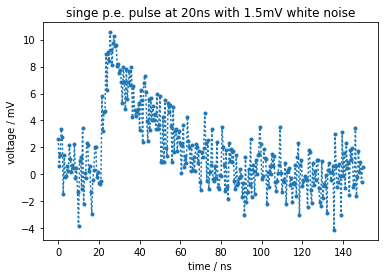

In [3]:
x = np.arange(0, 150, 0.5) # time in ns
y = fact_pulse_in_mV(x, 20)
y += np.random.normal(0, 1.5, size=len(y))
plt.plot(x, y, '.:')
plt.ylabel('voltage / mV')
plt.xlabel('time / ns')
plt.title("singe p.e. pulse at 20ns with 1.5mV white noise")
None

In [4]:
gain = 242 # mv slices

def basic_extraction(data):
    maxpos = np.argmax(data)
    maxHalf = data[maxpos] / 2.
    half_pos = np.where(data[:maxpos+1] > maxHalf)[0][0]-1
    integral = data[half_pos:half_pos+30].sum() / gain
    return {
        'maxpos': maxpos, 
        'maxHalf': maxHalf,
        'arrivalTime': x[half_pos],
        'integral': integral,
    }

In [5]:
df = []
for noise in tqdm(np.arange(1e-7, 5, 0.1)):
    for i in range(1000):
        y = fact_pulse_in_mV(x, 20)
        y += np.random.normal(0, noise, size=len(y))
        d = basic_extraction(y)
        d['noise'] = noise
        df.append(d)
df = pd.DataFrame(df)

100%|██████████| 50/50 [00:03<00:00, 16.71it/s]


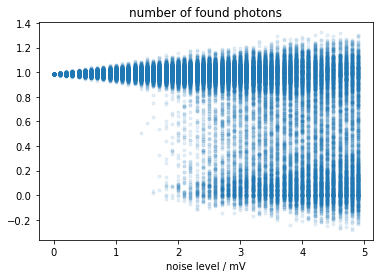

In [6]:
plt.plot(df.noise, df.integral, '.', alpha=0.1)
plt.title("number of found photons")
plt.xlabel("noise level / mV")
None

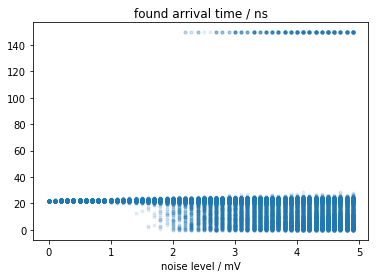

In [7]:
plt.plot(df.noise, df.arrivalTime, '.', alpha=0.1)
plt.title('found arrival time / ns')
plt.xlabel("noise level / mV")
None

### Two photons

In [8]:
df = []
for noise in tqdm(np.arange(1e-7, 5, 0.1)):
    for i in range(1000):
        y = 2 * fact_pulse_in_mV(x, 20)
        y += np.random.normal(0, noise, size=len(y))
        d = basic_extraction(y)
        d['noise'] = noise
        df.append(d)
df = pd.DataFrame(df)

100%|██████████| 50/50 [00:03<00:00, 16.46it/s]


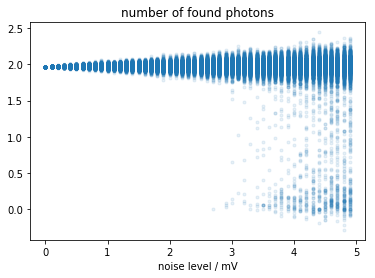

In [9]:
plt.plot(df.noise, df.integral, '.', alpha=0.1)
plt.title("number of found photons")
plt.xlabel("noise level / mV")
None

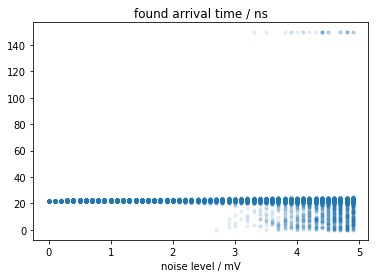

In [10]:
plt.plot(df.noise, df.arrivalTime, '.', alpha=0.1)
plt.title('found arrival time / ns')
plt.xlabel("noise level / mV")
None